In [1]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score
import polars as pl

TARGET = "HeartDiseaseorAttack"

def fetch_data(df, use_split, rbf=False, scale_col=True):
    assert(use_split >= 0 and use_split <= 4)
    # Perform 5-fold cross validation with a deterministic seed
    kf = KFold(n_splits=5, shuffle=True, random_state=2023)
    splits = list(kf.split(df))
    # Indexing the dataframe with an array returns the appropriate splits
    df_train, df_test = df[splits[use_split][0]], df[splits[use_split][1]]
    if scale_col:
        for col in df_train.columns:
            if col == TARGET:
                continue
            df_train, df_test = scale_column(df_train, df_test, col)
    cols = list(df_train.columns)
    if rbf:
        for col in cols:
            if col == TARGET:
                continue
            df_train, df_test = rbf_column(df_train, df_test, col) # Use radial bias function
    return df_train, df_test

def scale_column(df_train, df_test, col_name):
    max = df_train.get_column(col_name).max()
    min = df_train.get_column(col_name).min()
    df_train = df_train.with_columns((pl.col(col_name) - min) / (max - min))
    df_test = df_test.with_columns((pl.col(col_name) - min) / (max - min))
    return df_train, df_test

def rbf_column(df_train, df_test, col_name):
    std = df_train.get_column(col_name).std()
    low = df_train.get_column(col_name).quantile(0.25)
    middle = df_train.get_column(col_name).quantile(0.5)
    high = df_train.get_column(col_name).quantile(0.75)
    for i, val in enumerate([low, middle, high]):
        df_train = df_train.with_columns((-1.0 * (pl.col(col_name) - val)**2 / (2 * std)**2).exp().alias(f"{col_name}_{i}"))
        df_test = df_test.with_columns((-1.0 * (pl.col(col_name) - val)**2 / (2 * std)**2).exp().alias(f"{col_name}_{i}"))
    return df_train.drop(col_name), df_test.drop(col_name)

def get_x_y(df):
    X, y = df.drop(TARGET), df.get_column(TARGET)
    X = X.with_columns(pl.lit(1.0).alias('constant')) # extra column for the bias term
    return X.to_numpy(), y.to_numpy()

df = pl.read_csv("heart_disease.csv", has_header=True)

# data = load_digits(n_class=2)
# df = pl.DataFrame(data.data)
# df = df.with_columns(pl.Series(name='target', values=data.target)) 
# for col_id in range(64):
#     col = f"column_{col_id}"
#     df = df.with_columns(pl.col(col) / 8.0)

df_train, df_test = fetch_data(df, 0)
X_train, y_train = get_x_y(df_train)
X_test, y_test = get_x_y(df_test)
df_train.tail()

HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,1.0,1.0,1.0,0.383721,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.5,0.0,0.166667,0.0,1.0,0.333333,1.0,0.857143
0.0,1.0,1.0,1.0,0.069767,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.75,0.0,0.0,1.0,0.0,0.833333,0.2,0.428571
0.0,0.0,0.0,1.0,0.186047,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.8,0.142857
0.0,1.0,0.0,1.0,0.127907,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.5,0.0,0.0,0.0,1.0,0.5,0.8,0.0
1.0,1.0,1.0,1.0,0.151163,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.666667,1.0,0.142857


In [2]:
import numpy as np

def sigmoid(x):
    if x > 1e4:
        return 1.0
    elif x < -1e4:
        return 0.0
    return 1./(1. + np.exp(-x))

def error(x, y, w):
    inside = sigmoid(np.dot(w, x))
    if inside == 0.0:
        if y == 1:
            return 10000000.0
        else:
            return 0.0
    elif inside == 1.0:
        if y == 1:
            return 0.0
        else:
            return 10000000.0
    
    return -(y * np.log(inside) + (1 - y) * np.log(1 - inside))

def error_gradient(x, y, w, lamb, scale_grad=1.0):
    scale = max(1.0, scale_grad * y)
    return scale * x * (sigmoid(np.dot(w, x)) - y) + lamb * w # Slides seem wrong, gradient should point towards 0 weight

def sgd(X, Y, lr, lamb=0, epochs=2, scale_grad=1.0):
    w = np.random.random(size=X[0].size)
    # w = np.ones_like(X[0])
    err_avg = []

    for _ in range(epochs):
        err = []
        for (x, y) in zip(X, Y):
            w = w - lr * error_gradient(x, y, w, lamb, scale_grad=scale_grad)
            err.append(error(x, y, w))
        err_avg.append(np.mean(err))
    
    return w, err_avg

In [32]:
# Lambdas are very low since the weight penalty is being applied on every sgd step
l = [1e-6, 1e-5, 1e-4]

def logistic_regression(X, y, lambdas, scale_grad=1.0):
    weights, errors = [], []
    for l in lambdas:
        w, err = sgd(X, y, 5e-3, lamb=l, scale_grad=scale_grad)
        weights.append(w)
        errors.append(err)
    return weights, errors

weights, errors = logistic_regression(X_train, y_train, l)

In [5]:
(y_train == 0).sum() / len(y_train)

SeriesView(0.90579667)

In [41]:
from sklearn.linear_model import LogisticRegression

class Score:
    def __init__(self, preds, y):
        self.score = (np.count_nonzero(preds == y)) / len(y)
        self.conf = confusion_matrix(y, preds)
        self.f1 = f1_score(y, preds)

def score(X, y, w):
    preds = np.array([sigmoid(np.dot(x, w)) for x in X])
    preds = np.rint(preds)
    return Score(preds, y)

def run_experiment(df, use_split, lambdas, rbf=False, scale_grad=1.0):
    df_train, df_test = fetch_data(df, use_split, rbf=rbf)
    X_train, y_train = get_x_y(df_train)
    X_test, y_test = get_x_y(df_test)
    all_weights, _ = logistic_regression(X_train, y_train, lambdas, scale_grad=scale_grad)
    scores = [score(X_test, y_test, w) for w in all_weights]
    return scores

def sk_bench(df, use_split, rbf=False):
    df_train, df_test = fetch_data(df, use_split, rbf=rbf)
    X_train, y_train = get_x_y(df_train)
    X_test, y_test = get_x_y(df_test)
    model = LogisticRegression(solver='newton-cg', random_state=0).fit(X_train, y_train)
    pred = model.predict(X_test)
    return Score(pred, y_test)

In [26]:
experiments = [run_experiment(df, x, l, rbf=False) for x in range(5)]

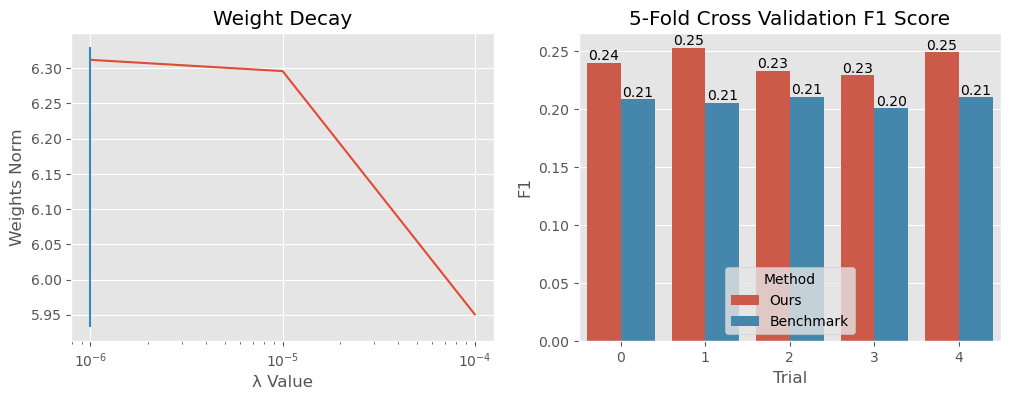

In [27]:
import seaborn
import pandas as pd 
import matplotlib.pyplot as plt

plt.style.use('ggplot')
scores = np.stack([[x.f1 for x in list] for list in experiments])

COLORS = seaborn.color_palette()
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(l, [np.linalg.norm(x) for x in weights], color=COLORS[0])
ax[0].vlines(l[scores.mean(axis=0).argmax()], ymin=ax[0].get_ylim()[0], ymax=ax[0].get_ylim()[1], color=COLORS[1])
ax[0].set_xscale('log')
ax[0].set_ylabel('Weights Norm')
ax[0].set_xlabel('λ Value')
ax[0].set_title('Weight Decay')

our_method = scores.max(axis=1).tolist()
benchmark = [sk_bench(df, x, rbf=False).f1 for x in range(5)]
method = ['Ours' for _ in range(5)] + ['Benchmark' for _ in range(5)]
plot_df = pd.DataFrame.from_dict({'F1': our_method + benchmark, 'Method': method, 'Trial': list(range(5)) + list(range(5))})
ax[1].set_title('5-Fold Cross Validation F1 Score')
seaborn.barplot(data=plot_df, x='Trial', y='F1', hue='Method', ax=ax[1], palette=COLORS)
seaborn.move_legend(ax[1], "lower center")
for container in ax[1].containers:
    ax[1].bar_label(container, fmt="%.2f")

In [69]:
weights[0]

array([ 0.64438786,  0.54164366, -0.32039187, -0.89403849,  0.28508514,
        1.0263559 ,  0.34481427,  0.05569112,  0.11705781, -0.08281724,
       -0.38176842, -0.3116902 ,  0.17306522,  1.73152697,  0.11984764,
        0.20516072,  0.36886384,  0.62433353,  2.62348346, -0.22946999,
       -0.34852307, -5.02874328])

We can see that the precision is high for both classes, but the recall is very low for the value of 1 (heart disease or heart attack). This is to be expected since the dataset is unbalanced, with 90% of cases in the zero class. We can try to improve this by setting different weights for the two classes. 

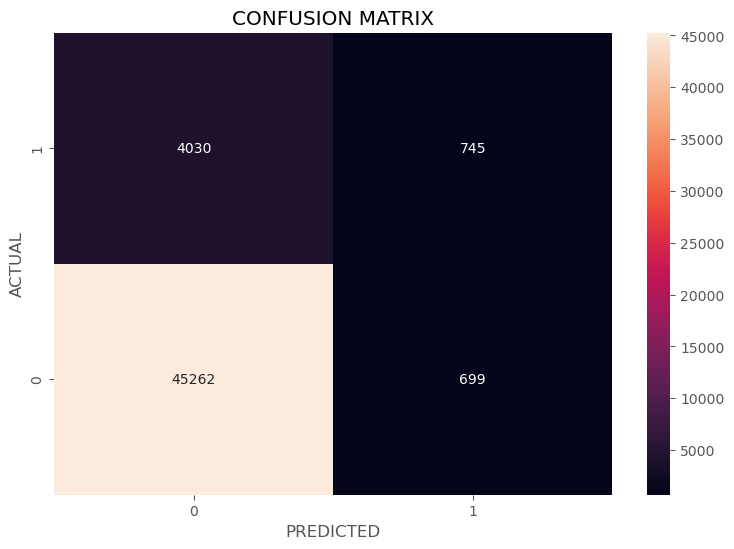

In [30]:
plt.figure(figsize = (9,6))
ax = seaborn.heatmap(experiments[0][0].conf, annot=True, fmt='g')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.title('CONFUSION MATRIX')
ax.set_ylim(0, 2)
plt.show()

In [57]:
scale = np.linspace(1, 5, 9)
scale_loss_exp = [run_experiment(df, 0, [l[0]], rbf=False, scale_grad=x) for x in scale]

In [56]:
np.linspace(1, 5, 9)

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

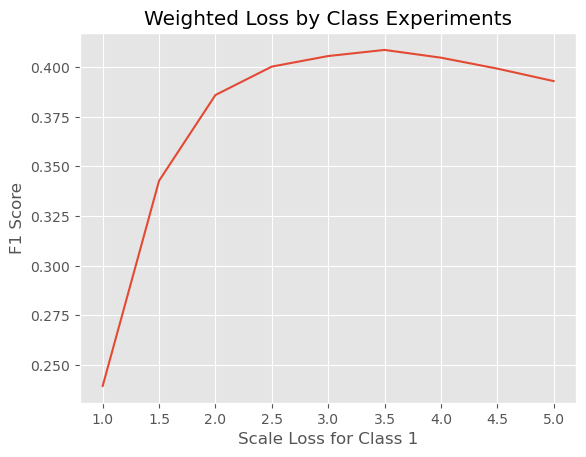

In [58]:
y_vals = [scale_loss_exp[i][0].f1 for i in range(len(scale_loss_exp))]
x = scale
f, ax = plt.subplots()
ax.set_ylabel("F1 Score")
ax.set_xlabel("Scale Loss for Class 1")
ax.set_title("Weighted Loss by Class Experiments")
ax.plot(x, y_vals)

In [60]:
rbf_exp = [run_experiment(df, x, l, rbf=True, scale_grad=3.5) for x in range(5)]
experiments = [run_experiment(df, x, l, rbf=False, scale_grad=3.5) for x in range(5)]

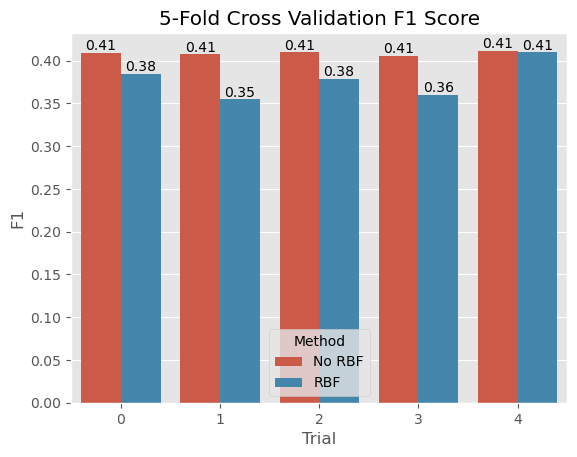

In [67]:
plt.style.use('ggplot')
scores = np.stack([[x.f1 for x in list] for list in experiments])
rbf_scores = np.stack([[x.f1 for x in list] for list in rbf_exp])

COLORS = seaborn.color_palette()
f, ax = plt.subplots()

no_rbf = scores.max(axis=1).tolist()
rbf = rbf_scores.max(axis=1).tolist()

method = ['No RBF' for _ in range(5)] + ['RBF' for _ in range(5)]
plot_df = pd.DataFrame.from_dict({'F1': no_rbf + rbf, 'Method': method, 'Trial': list(range(5)) + list(range(5))})
ax.set_title('5-Fold Cross Validation F1 Score')
seaborn.barplot(data=plot_df, x='Trial', y='F1', hue='Method', ax=ax, palette=COLORS)
seaborn.move_legend(ax, "lower center")
# ax.bar_label(container, fmt="%.2f")
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")

With the scaled loss, we tradeoff much better recall for the rare class with a higher false positive rate. 

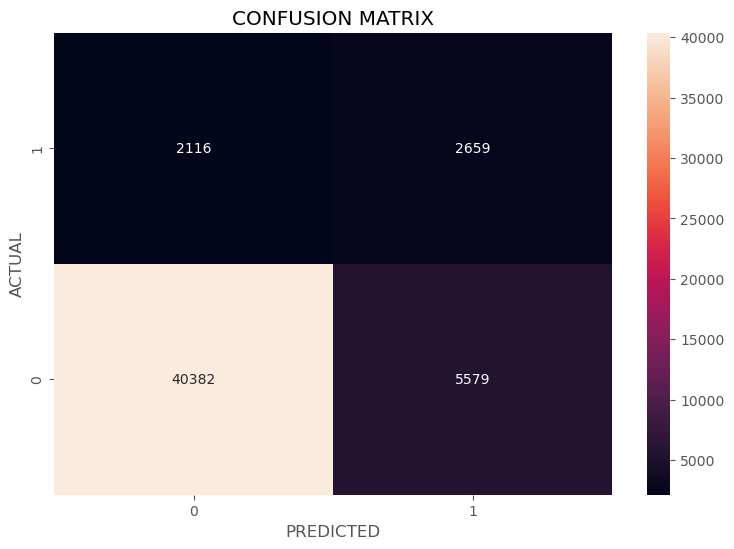

In [68]:
plt.figure(figsize = (9,6))
ax = seaborn.heatmap(experiments[0][0].conf, annot=True, fmt='g')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.title('CONFUSION MATRIX')
ax.set_ylim(0, 2)
plt.show()